# Visualizing the stock market structure
http://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html#stock-market

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This example employs several unsupervised learning techniques to extract the stock market structure from variations in historical quotes.

The quantity that we use is the daily variation in quote price: quotes that are linked tend to cofluctuate during a day.

## Learning a graph structure
We use sparse inverse covariance estimation to find which quotes are correlated conditionally on the others. Specifically, sparse inverse covariance gives us a graph, that is a list of connection. For each symbol, the symbols that it is connected too are those useful to explain its fluctuations.

## Clustering
We use clustering to group together quotes that behave similarly. Here, amongst the various clustering techniques available in the scikit-learn, we use Affinity Propagation as it does not enforce equal-size clusters, and it can choose automatically the number of clusters from the data.

Note that this gives us a different indication than the graph, as the graph reflects conditional relations between variables, while the clustering reflects marginal properties: variables clustered together can be considered as having a similar impact at the level of the full stock market.

## Embedding in 2D space
For visualization purposes, we need to lay out the different symbols on a 2D canvas. For this we use Manifold learning techniques to retrieve 2D embedding.

## Visualization
The output of the 3 models are combined in a 2D graph where nodes represents the stocks and edges the:

cluster labels are used to define the color of the nodes
the sparse covariance model is used to display the strength of the edges
the 2D embedding is used to position the nodes in the plan
This example has a fair amount of visualization-related code, as visualization is crucial here to display the graph. One of the challenge is to position the labels minimizing overlap. For this we use an heuristic based on the direction of the nearest neighbor along each axis.

<img src='http://scikit-learn.org/stable/_images/sphx_glr_plot_stock_market_001.png'>

Automatically created module for IPython interactive environment


Fetching quote history for 'NASDAQ:AAPL'
Fetching quote history for 'NASDAQ:AMZN'
Fetching quote history for 'NASDAQ:CMCSA'
Fetching quote history for 'NASDAQ:CSCO'
Fetching quote history for 'NASDAQ:DELL'
Fetching quote history for 'NASDAQ:MAR'
Fetching quote history for 'NASDAQ:MSFT'
Fetching quote history for 'NASDAQ:TXN'
Fetching quote history for 'NASDAQ:YHOO'
Fetching quote history for 'NYSE:AIG'
Fetching quote history for 'NYSE:AXP'
Fetching quote history for 'NYSE:BA'
Fetching quote history for 'NYSE:BAC'
Fetching quote history for 'NYSE:CAJ'
Fetching quote history for 'NYSE:CAT'
Fetching quote history for 'NYSE:CL'
Fetching quote history for 'NYSE:COP'
Fetching quote history for 'NYSE:CVC'
Fetching quote history for 'NYSE:CVS'
Fetching quote history for 'NYSE:CVX'
Fetching quote history for 'NYSE:DD'
Fetching quote history for 'NYSE:F'
Fetching quote history for 'NYSE:GD'
Fetching quote history for 'NYSE:GE'
Fetching quote history for 'NYSE:GS'
Fetching quote history for 'NYSE

Cluster 1: Apple, Amazon, Yahoo
Cluster 2: Cisco, Dell, Microsoft, Texas Instruments, HP, IBM, SAP
Cluster 3: American express
Cluster 4: Boeing
Cluster 5: Cablevision
Cluster 6: ConocoPhillips, Chevron, Total, Valero Energy, Exxon
Cluster 7: Comcast, Marriott, AIG, Bank of America, CVS, DuPont de Nemours, Ford, General Electrics, Goldman Sachs, Home Depot, JPMorgan Chase, McDonald's, 3M, Pfizer, Ryder, Wells Fargo, Wal-Mart
Cluster 8: Navistar
Cluster 9: General Dynamics, Northrop Grumman, Raytheon
Cluster 10: GlaxoSmithKline, Novartis, Sanofi-Aventis
Cluster 11: Kellogg, Coca Cola, Pepsi
Cluster 12: Colgate-Palmolive, Kimberly-Clark, Procter Gamble
Cluster 13: Canon, Caterpillar, Honda, Sony, Toyota, Unilever, Xerox
Cluster 14: Time Warner


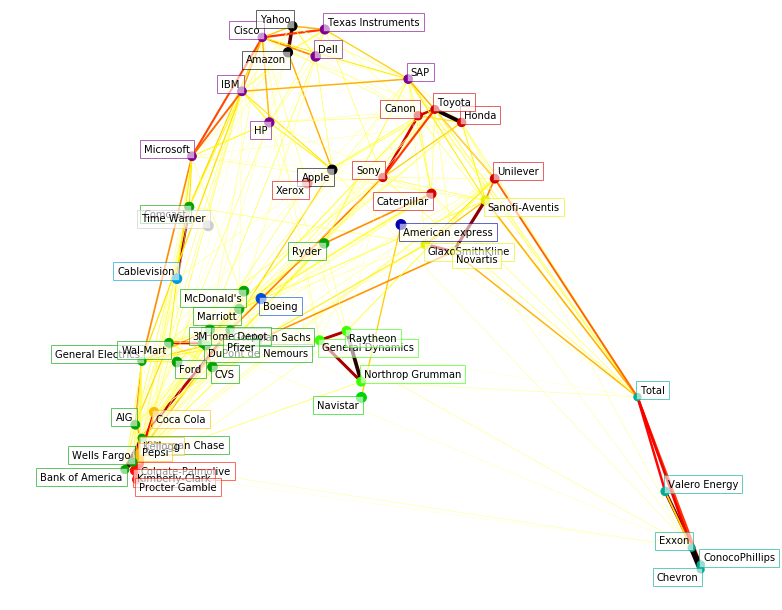

In [2]:
import sys
from datetime import datetime 

from matplotlib.collections import LineCollection
from six.moves.urllib.request import urlopen
from six.moves.urllib.parse import urlencode
from sklearn import cluster, covariance, manifold

print(__doc__)


def retry(f, n_attempts=3):
    "Wrapper function to retry function calls in case of exceptions"
    def wrapper(*args, **kwargs):
        for i in range(n_attempts):
            try:
                return f(*args, **kwargs)
            except Exception:
                if i == n_attempts - 1:
                    raise
    return wrapper


def quotes_historical_google(symbol, start_date, end_date):
    """Get the historical data from Google finance.

    Parameters
    ----------
    symbol : str
        Ticker symbol to query for, for example ``"DELL"``.
    start_date : datetime.datetime
        Start date.
    end_date : datetime.datetime
        End date.

    Returns
    -------
    X : array
        The columns are ``date`` -- date, ``open``, ``high``,
        ``low``, ``close`` and ``volume`` of type float.
    """
    params = {
        'q': symbol,
        'startdate': start_date.strftime('%Y-%m-%d'),
        'enddate': end_date.strftime('%Y-%m-%d'),
        'output': 'csv',
    }
    url = 'https://finance.google.com/finance/historical?' + urlencode(params)
    response = urlopen(url)
    dtype = {
        'names': ['date', 'open', 'high', 'low', 'close', 'volume'],
        'formats': ['object', 'f4', 'f4', 'f4', 'f4', 'f4']
    }
    converters = {
        0: lambda s: datetime.strptime(s.decode(), '%d-%b-%y').date()}
    data = np.genfromtxt(response, delimiter=',', skip_header=1,
                         dtype=dtype, converters=converters,
                         missing_values='-', filling_values=-1)
    min_date = min(data['date'], default=datetime.min.date())
    max_date = max(data['date'], default=datetime.max.date())
    start_end_diff = (end_date - start_date).days
    min_max_diff = (max_date - min_date).days
    data_is_fine = (
        start_date <= min_date <= end_date and
        start_date <= max_date <= end_date and
        start_end_diff - 7 <= min_max_diff <= start_end_diff)

    if not data_is_fine:
        message = (
            'Data looks wrong for symbol {}, url {}\n'
            '  - start_date: {}, end_date: {}\n'
            '  - min_date:   {}, max_date: {}\n'
            '  - start_end_diff: {}, min_max_diff: {}'.format(
                symbol, url,
                start_date, end_date,
                min_date, max_date,
                start_end_diff, min_max_diff))
        raise RuntimeError(message)
    return data

# #############################################################################
# Retrieve the data from Internet

# Choose a time period reasonably calm (not too long ago so that we get
# high-tech firms, and before the 2008 crash)
start_date = datetime(2003, 1, 1).date()
end_date = datetime(2008, 1, 1).date()

symbol_dict = {
    'NYSE:TOT': 'Total',
    'NYSE:XOM': 'Exxon',
    'NYSE:CVX': 'Chevron',
    'NYSE:COP': 'ConocoPhillips',
    'NYSE:VLO': 'Valero Energy',
    'NASDAQ:MSFT': 'Microsoft',
    'NYSE:IBM': 'IBM',
    'NYSE:TWX': 'Time Warner',
    'NASDAQ:CMCSA': 'Comcast',
    'NYSE:CVC': 'Cablevision',
    'NASDAQ:YHOO': 'Yahoo',
    'NASDAQ:DELL': 'Dell',
    'NYSE:HPQ': 'HP',
    'NASDAQ:AMZN': 'Amazon',
    'NYSE:TM': 'Toyota',
    'NYSE:CAJ': 'Canon',
    'NYSE:SNE': 'Sony',
    'NYSE:F': 'Ford',
    'NYSE:HMC': 'Honda',
    'NYSE:NAV': 'Navistar',
    'NYSE:NOC': 'Northrop Grumman',
    'NYSE:BA': 'Boeing',
    'NYSE:KO': 'Coca Cola',
    'NYSE:MMM': '3M',
    'NYSE:MCD': 'McDonald\'s',
    'NYSE:PEP': 'Pepsi',
    'NYSE:K': 'Kellogg',
    'NYSE:UN': 'Unilever',
    'NASDAQ:MAR': 'Marriott',
    'NYSE:PG': 'Procter Gamble',
    'NYSE:CL': 'Colgate-Palmolive',
    'NYSE:GE': 'General Electrics',
    'NYSE:WFC': 'Wells Fargo',
    'NYSE:JPM': 'JPMorgan Chase',
    'NYSE:AIG': 'AIG',
    'NYSE:AXP': 'American express',
    'NYSE:BAC': 'Bank of America',
    'NYSE:GS': 'Goldman Sachs',
    'NASDAQ:AAPL': 'Apple',
    'NYSE:SAP': 'SAP',
    'NASDAQ:CSCO': 'Cisco',
    'NASDAQ:TXN': 'Texas Instruments',
    'NYSE:XRX': 'Xerox',
    'NYSE:WMT': 'Wal-Mart',
    'NYSE:HD': 'Home Depot',
    'NYSE:GSK': 'GlaxoSmithKline',
    'NYSE:PFE': 'Pfizer',
    'NYSE:SNY': 'Sanofi-Aventis',
    'NYSE:NVS': 'Novartis',
    'NYSE:KMB': 'Kimberly-Clark',
    'NYSE:R': 'Ryder',
    'NYSE:GD': 'General Dynamics',
    'NYSE:RTN': 'Raytheon',
    'NYSE:CVS': 'CVS',
    'NYSE:CAT': 'Caterpillar',
    'NYSE:DD': 'DuPont de Nemours'}


symbols, names = np.array(sorted(symbol_dict.items())).T

# retry is used because quotes_historical_google can temporarily fail
# for various reasons (e.g. empty result from Google API).
quotes = []

for symbol in symbols:
    print('Fetching quote history for %r' % symbol, file=sys.stderr)
    quotes.append(retry(quotes_historical_google)(
        symbol, start_date, end_date))

close_prices = np.vstack([q['close'] for q in quotes])
open_prices = np.vstack([q['open'] for q in quotes])

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices


# #############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

# #############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()